In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
sys.path.insert(0, '../')

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

import Spectrogram

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Network Parameters
epochs = 35
train_size = 100000
test_size = 50000
epsilon = 1e-5
fs = 44100

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               "Mir_Eval": [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter
result_dict['parameters']['window'] = window

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 37.87 seconds


# Defining Models

In [6]:
Loss = torch.nn.BCELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [60]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Getting Mel Spectrogram on the fly
        resolution = 4
        self.n_bins = 84*resolution
        self.bins_per_octave = 12*resolution
        self.spec_layer = Spectrogram.MelSpectrogram(n_mels=255)
            
        # Creating Layers
        k_out = 128
        self.CNN_freq_kernel_size=(128,1)
        self.CNN_freq_kernel_stride=(2,1)
        k2_out = 256
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=self.CNN_freq_kernel_size,stride=self.CNN_freq_kernel_stride)
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,33),stride=(1,1))    
        
        self.region_v = 1 + (255-self.CNN_freq_kernel_size[0])//self.CNN_freq_kernel_stride[0]
        print("versize = ", self.region_v)
        self.linear = torch.nn.Linear(k2_out*self.region_v, m, bias=False)
        
        
        
    def forward(self,x):
        z = self.spec_layer(x)
        z = torch.log(z+epsilon)
        z2 = torch.relu(self.CNN_freq(z.unsqueeze(1)))
        z3 = torch.relu(self.CNN_time(z2))
        y = self.linear(torch.relu(torch.flatten(z3,1)))
        return torch.sigmoid(y)
    

In [61]:
model = Model()
model.to(device)

versize =  64


Model(
  (spec_layer): MelSpectrogram()
  (CNN_freq): Conv2d(1, 128, kernel_size=(128, 1), stride=(2, 1))
  (CNN_time): Conv2d(128, 256, kernel_size=(1, 33), stride=(1, 1))
  (linear): Linear(in_features=16384, out_features=128, bias=False)
)

In [62]:
model(x)

tensor([[0.4982, 0.1907, 0.6737,  ..., 0.6684, 0.2857, 0.4374],
        [0.5007, 0.1624, 0.6906,  ..., 0.6559, 0.2847, 0.4306],
        [0.5355, 0.2379, 0.6818,  ..., 0.6230, 0.2954, 0.4160],
        ...,
        [0.5043, 0.1547, 0.7079,  ..., 0.6563, 0.3101, 0.4170],
        [0.4714, 0.1659, 0.6789,  ..., 0.6579, 0.2594, 0.4437],
        [0.4804, 0.2149, 0.6306,  ..., 0.5234, 0.2667, 0.4583]],
       grad_fn=<SigmoidBackward>)

In [22]:
mel_layer = Spectrogram.MelSpectrogram(sr=44100, fmin=55, fmax=6000)
STFT_layer = Spectrogram.STFT(sr=44100, n_fft=2048, fmin=50, fmax=6000, freq_scale='log', pad_mode='constant')

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range


In [23]:
mel_layer(x)[0].cpu().numpy().shape

(128, 33)

Text(0.5, 1.0, 'Melspectrogram')

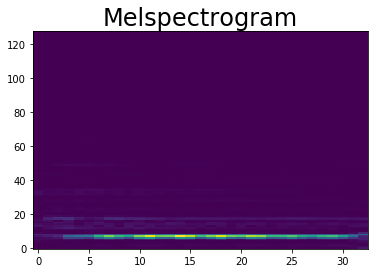

In [14]:
plt.imshow(mel_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("Melspectrogram", size=24)

Text(0.5, 1.0, 'STFT Log')

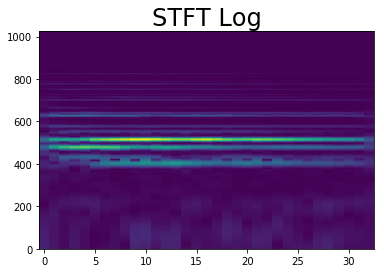

In [28]:
plt.imshow(STFT_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("STFT Log", size=24)

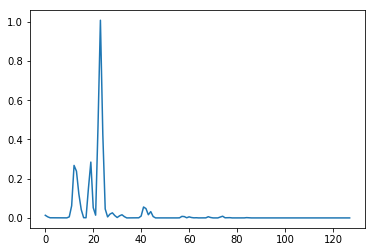

In [37]:
plt.plot(mel_layer(x)[0].cpu().numpy()[:,10])

# CQT

In [29]:
from librosa import cqt

In [39]:
lib_result = abs(cqt(x[0].cpu().numpy(), sr=44100, fmin=55, n_bins=84*4, bins_per_octave=48, pad_mode='constant'))

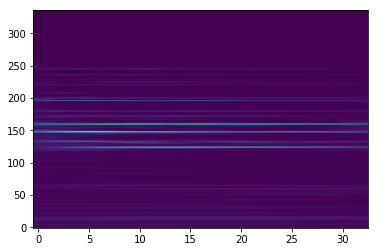

In [40]:
plt.imshow(lib_result, aspect='auto', origin='lower')

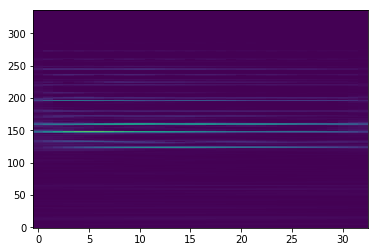

In [38]:
torch_result = model.cqt_layer(x)[0].cpu().numpy()
plt.imshow(torch_result, aspect='auto', origin='lower')

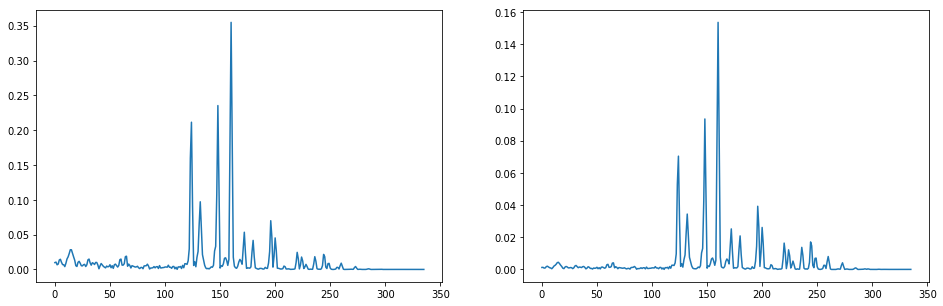

In [41]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(lib_result[:, 10])
ax[1].plot(torch_result[:, 10])

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
        yhat = torch.Tensor(batch_size*len(train_loader), m)
        avgp, loss_e = 0.,0
        t = time()
        for i, (x,y) in enumerate(train_loader):
            x = x.to(device)
            break
except:
    pass

epoch	train loss	test loss	train avg	test avg	time	utime
